# Nengo example: Routed sequencing

This demo uses the basal ganglia model to cycle through a 5 element sequence, where an arbitrary start can be presented to the model. The addition of routing allows the system to choose between two different actions: whether to go through the sequence, or be driven by the visual input. If the visual input has its value set to 0.8*START+D (for instance), it will begin cycling through at D$\rightarrow$E, etc. The 0.8 scaling helps ensure start is unlikely to accidently match other SPAs (which can be a problem in low dimensional examples like this one).

In [1]:
# Setup for the notebook
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
import nengo_spa as spa

## Step 1: Create the model

Notice that when you specify actions, you're determining which modules are connected to which. For example, by having a mapping that depends on the state of cortex, you are determining that the cortex and basal ganglia must be connected. As well, when you specify that the result of the action changes the state of cortex, then you are determining that thalamus must be connected to cortex.


In [10]:
def start(t):
    if t < 0.1:
        return '0.8*START+D'
    else:
        return '0'

# Number of dimensions for the Semantic Pointers
dimensions = 16

# Make a model object with the SPA network
model = spa.Network(label='Routed_Sequence')

with model:
    # Specify the modules to be used
    model.vision = spa.Transcode(start, output_vocab=dimensions) 
    model.cortex = spa.State(dimensions)

    # Specify the action mapping
    with spa.ActionSelection() as action_sel:
        spa.ifmax("Start", spa.dot(model.vision, spa.sym.START),
            model.vision >> model.cortex)
        spa.ifmax("A to B", spa.dot(model.cortex, spa.sym.A),
            spa.sym.B >> model.cortex)
        spa.ifmax("B to C", spa.dot(model.cortex, spa.sym.B),
            spa.sym.C >> model.cortex)
        spa.ifmax("C to D", spa.dot(model.cortex, spa.sym.C),
            spa.sym.D >> model.cortex)
        spa.ifmax("D to E", spa.dot(model.cortex, spa.sym.D),
            spa.sym.E >> model.cortex)
        spa.ifmax("E to A", spa.dot(model.cortex, spa.sym.E),
            spa.sym.A >> model.cortex)

## Step 3: Probe the output

In [3]:
with model:
    cortex = nengo.Probe(model.cortex.output, synapse=0.01)
    vision = nengo.Probe(model.vision.output, synapse=0.01)
    selected_actions = nengo.Probe(action_sel.thalamus.output, synapse=0.01)
    utility = nengo.Probe(action_sel.bg.input, synapse=0.01)

## Step 4: Run the model

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

Building finished in 0:00:02.                                                   
Simulating finished in 0:00:05.                                                 


## Step 5: Plot the results

Text(0.5,0,'Time (s)')

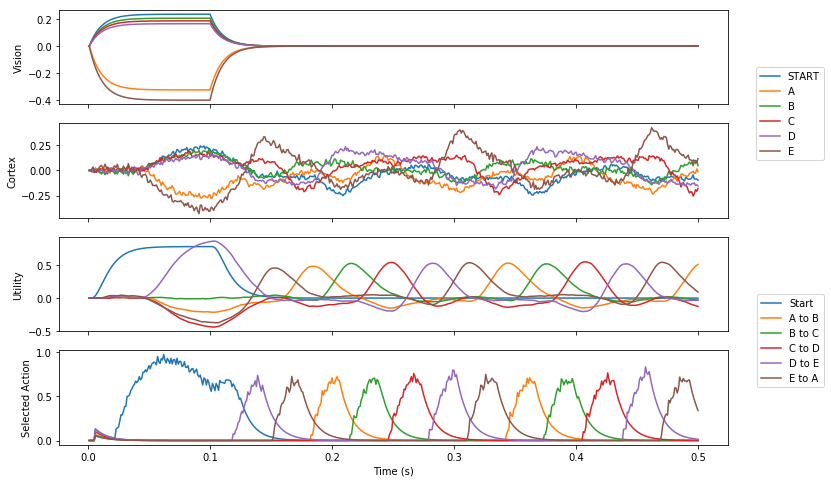

In [51]:
vocab = model.vocabs[dimensions]

fig, (p1, p2, p3, p4) = plt.subplots(4, 1, sharex=True, figsize=(12,8))
p1.plot(sim.trange(), spa.similarity(sim.data[vision], vocab))
p1.legend(vocab.keys(), loc='right', bbox_to_anchor=(1.15, -0.1))
p1.set_ylabel('Vision')

p2.plot(sim.trange(), spa.similarity(sim.data[cortex], vocab))
p2.set_ylabel('Cortex')

p3.plot(sim.trange(), sim.data[utility])
p3.legend(tuple(action_sel.keys()), loc='right', bbox_to_anchor=(1.15, -0.1))
p3.set_ylabel('Utility')

p4.plot(sim.trange(), sim.data[selected_actions])
p4.set_ylabel('Selected Action')
p4.set_xlabel("Time (s)")